## Consumer Discretionary Model

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae

### Load target variable data

In [2]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('../../data/raw/con_disc_pe_ratio.csv')
pe_ratio.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS
0,Aug-21-2001,31.70x
1,Aug-22-2001,31.80x
2,Aug-23-2001,31.69x
3,Aug-24-2001,32.48x
4,Aug-27-2001,32.17x


In [3]:
# load consumer discretionary index price -- also from Capital IQ
price = pd.read_csv('../../data/raw/con_disc_price.csv')
price.head()

,Dates,S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value
0,Sep-11-1989,77.33
1,Sep-12-1989,77.33
2,Sep-13-1989,76.32
3,Sep-14-1989,75.53
4,Sep-15-1989,75.66


In [4]:
# load 10 year treasury rate
treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [5]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - P/Normalized EPS" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-21,31.70
2001-08-22,31.80
2001-08-23,31.69
2001-08-24,32.48
2001-08-27,32.17


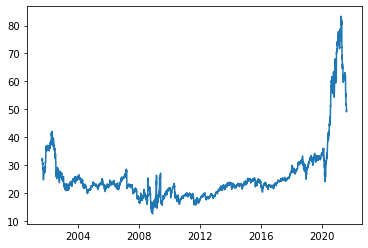

In [6]:
plt.plot(pe_ratio.PE)

In [7]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "S&P 500 Consumer Discretionary (Sector) (^SP500-25) - Index Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
1989-09-11,77.33
1989-09-12,77.33
1989-09-13,76.32
1989-09-14,75.53
1989-09-15,75.66


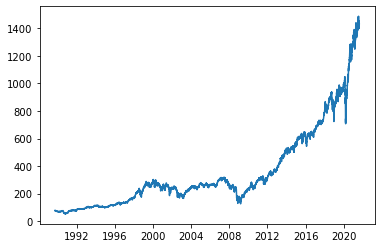

In [8]:
plt.plot(price.Price)

In [9]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


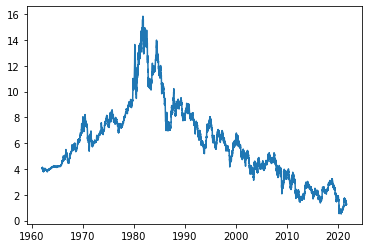

In [10]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [11]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-21,31.70,241.08,4.87
2001-08-22,31.80,241.63,4.91
2001-08-23,31.69,240.75,4.89
2001-08-24,32.48,246.84,4.93
2001-08-27,32.17,245.02,4.94


In [12]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      31.516667  239.642222       4.867778
     9      27.175333  204.901333       4.748667
     10     28.268696  211.766087       4.566818
     11     33.669524  230.619524       4.651500
     12     36.054000  238.324500       5.087500

In [13]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778
2001-09-01,2001,9,27.175333,204.901333,4.748667
2001-10-01,2001,10,28.268696,211.766087,4.566818
2001-11-01,2001,11,33.669524,230.619524,4.651500
2001-12-01,2001,12,36.054000,238.324500,5.087500


In [14]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210


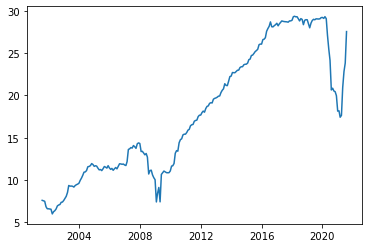

In [15]:
plt.plot(joined.earnings)

In [16]:
joined['earnings_change'] = joined.earnings.diff(1)
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change,ann_earnings_ch
date,,,,,,,,
2001-08-01,2001,8,31.516667,239.642222,4.867778,7.603666,NaN,NaN
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.063692,-5.460296e-01
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.048788,-4.513084e-01
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.641683,-9.999955e-01
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.239294,-9.624506e-01
...,...,...,...,...,...,...,...,...
2021-04-01,2021,4,80.362500,1417.672000,1.628000,17.640964,0.217982,9.658360e+00
2021-05-01,2021,5,65.739500,1376.421500,1.621000,20.937511,3.296547,3.957621e+07
2021-06-01,2021,6,60.907368,1390.399474,1.524211,22.828100,1.890589,3.402783e+05


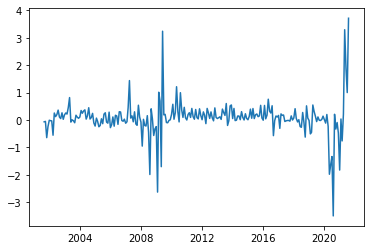

In [17]:
plt.plot(joined.earnings_change)

In [54]:
joined['target'] = joined.earnings_change - (1 + joined.treasury_rate/100)**(1/12) - 1
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,ann_earnings_ch,target
date,,,,,,,,,
2001-09-01,2001,9,27.175333,204.901333,4.748667,7.539975,-0.063692,-0.546030,-2.067565
2001-10-01,2001,10,28.268696,211.766087,4.566818,7.491187,-0.048788,-0.451308,-2.052516
2001-11-01,2001,11,33.669524,230.619524,4.651500,6.849504,-0.641683,-0.999996,-2.645479
2001-12-01,2001,12,36.054000,238.324500,5.087500,6.610210,-0.239294,-0.962451,-2.243438
2002-01-01,2002,1,36.128095,238.579524,5.035714,6.603712,-0.006498,-0.075249,-2.010601


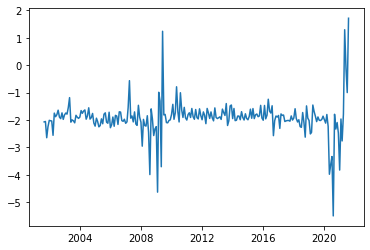

In [55]:
plt.plot(joined.target)

## SARIMA Model

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

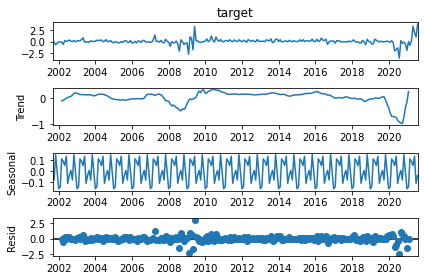

In [21]:
# look at seasonality
decomp_results = seasonal_decompose(joined['target'], period = 12)
decomp_results.plot()
plt.show()

In [22]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = joined.loc[:split_date]
y_train = train['target']

test =  joined.loc[split_date:]
y_test = test['target']

In [35]:
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic',
                      # trace = True, error_action = 'ignore', suppress_warnings = True
                     )
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  185
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -142.103
Date:                            Tue, 24 Aug 2021   AIC                            292.207
Time:                                    23:01:55   BIC                            304.820
Sample:                                         0   HQIC                           297.324
                                            - 185                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1329      0.053     -2.529      0.011      -0.236      -0.030
ar.S.L12      -0.6123      0.040   

In [38]:
model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (2,1,0,12),
                trend = 'c'
                # , exog = x_train
                )

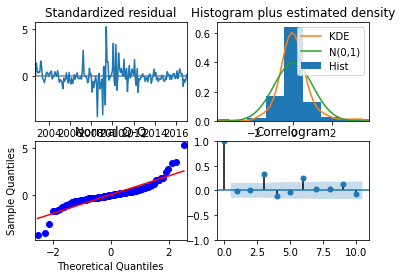

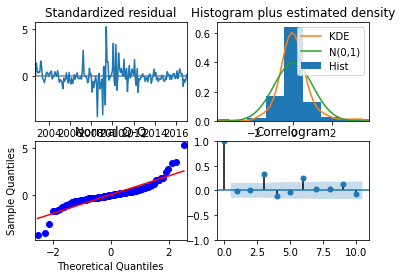

In [53]:
mod_fitted = model.fit()
mod_fitted.plot_diagnostics()

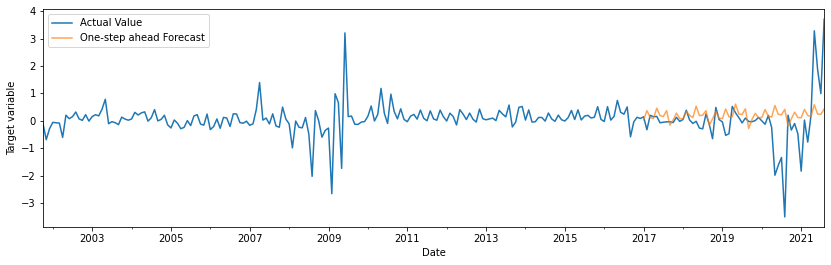

In [50]:
pred = mod_fitted.get_prediction(start = y_test.index[0], end = y_test.index[-1], 
                                 #exog = x_test.iloc[:-1,:], dynamic=False
                                )
ts_pred = pred.predicted_mean
pred_ci = pred.conf_int()
ax = joined.target['2001-10-01':].plot(label='Actual Value')
ts_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [52]:
print("MAPE:", round(mape(y_test, ts_pred), 3))
print("MAE:", round(mae(y_test, ts_pred), 3))

MAPE: 9.622
MAE: 0.605
